# Load the dataset and split

In [2]:
import numpy as np
import pandas as pd
import os, sys
from HELPpy.preprocess.loaders import load_features
from HELPpy.utility.utils import pandas_readcsv
from sklearn.model_selection import train_test_split
path = '/users/maurizio/HELP/data/'
attributes = load_features([os.path.join(path, 'Kidney_BIO.csv'), 
                            os.path.join(path, 'Kidney_CCcfs.csv'),
                            #os.path.join(path, 'Kidney_EmbN2V_128.csv')
                           ], 
                            fixnans=[False, False, False], normalizes=['std', 'std', None], verbose=False, show_progress=True)
labelnme = 'Kidney_HELP.csv'
label = pandas_readcsv(os.path.join(path,labelnme), descr=f'{labelnme}', index_col=0).replace({'E': 1, 'aE':0, 'sNE': 0})
idx_common = np.intersect1d(attributes.index.values, label.index.values)
attributes = attributes.loc[idx_common]
label = label.loc[idx_common]
dataset = pd.concat([attributes, label], axis=1)

Kidney_BIO.csv:   0%|          | 0/19293 [00:00<?, ?it/s]

Kidney_CCcfs.csv:   0%|          | 0/18608 [00:00<?, ?it/s]

Kidney_HELP.csv:   0%|          | 0/17829 [00:00<?, ?it/s]

In [39]:
len(pd.read_csv(os.path.join(path, 'Kidney_BIO.csv'), index_col=0).columns)


26

# Feature importance
Create a model with optima hyper-paramters and fit the entire dataset.

In [34]:
from HELPpy.models.prediction import VotingEnsembleLGBM
hparams = {"n_estimators" :200, "n_voters": 13, "learning_rate": 0.1, "boosting_type": "gbdt"}
velgbm = VotingEnsembleLGBM(**hparams)
velgbm.fit(attributes,label)

VotingEnsembleLGBM(boosting_type='gbdt', learning_rate=0.1, n_estimators=200,
                   n_jobs=-1, n_voters=13, random_state=42, verbose=False,
                   voting='soft')

Save feature importance scores and plot the features with score greater than 0.001 (i.e. consider only feature contributing with more than 0.1 %)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
plt.tight_layout()
df = pd.DataFrame({'Feature': get_config('X_train').columns, 'Importance' : velgbm.feature_importances_}).sort_values('Importance', ascending=False)
df.to_csv("veLGBM_feature_importance.csv")
reduced_features = df[df['Importance']>=0.001]['Feature'].values
with open(f"biocccfs_reduced_0.1imp.txt", 'w', encoding='utf-8') as f:
    f.write('\n'.join(list(reduced_features)))
ax = df[df['Importance']>=0.001].plot.bar(x='Feature', fontsize=7, y='Importance')
fig = ax.get_figure()
fig.tight_layout()
bioattrs = pd.read_csv(os.path.join(path, 'Kidney_BIO.csv'), index_col=0).columns
for tick, feat in zip(ax.get_children(),ax.get_xticklabels()):
    if feat.get_text() in bioattrs:
        tick.set_color('r')
legend_elements = [ Patch(facecolor='b', label='CCcfs'),Patch(facecolor='r', label='Bio')]
ax.legend(handles=legend_elements, loc='center')
ax.set_ylabel("Importance (%)")
fig.set_size_inches(14, 10)
#fig.savefig('veLGBM_feature_importance.png', dpi=600)

<Figure size 640x480 with 0 Axes>

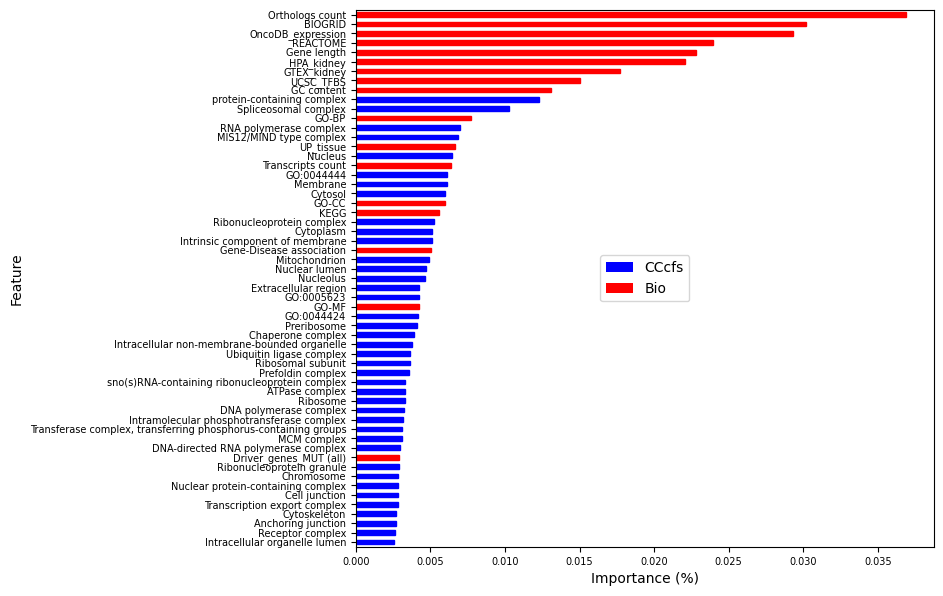

In [28]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pandas as pd
import os
plt.tight_layout()
respath = '../results'
path = '../data'
df = pd.read_csv(os.path.join(respath, "veLGBM_feature_importance.csv"), index_col=0)
ax = df[df['Importance']>=0.0025].sort_values('Importance', ascending=True).plot.barh(x='Feature', fontsize=7, y='Importance')
fig = ax.get_figure()
fig.tight_layout()
bioattrs = pd.read_csv(os.path.join(path, 'Kidney_BIO.csv'), index_col=0).columns
for tick, feat in zip(ax.get_children(),ax.get_yticklabels()):
    if feat.get_text() in bioattrs:
        tick.set_color('r')
    else:
        tick.set_color('b')
legend_elements = [ Patch(facecolor='b', label='CCcfs'),Patch(facecolor='r', label='Bio')]
ax.legend(handles=legend_elements, loc='center')
ax.set_xlabel("Importance (%)")
fig.set_size_inches(14, 6)
#fig.savefig('veLGBM_feature_importance.png', dpi=600)

# Get the performance on reduced dataset

In [48]:
from HELPpy.models.prediction import VotingEnsembleLGBM, k_fold_cv
clf = VotingEnsembleLGBM(**hparams)
df_scores, scores, predictions = k_fold_cv(attributes[reduced_features], label, clf, n_splits=5, seed=0, show_progress=True, verbose=True)
df_scores

{0: 0, 1: 1}
label
0        15994
1         1242
Name: count, dtype: int64



5-fold:   0%|          | 0/5 [00:00<?, ?it/s]

,measure
ROC-AUC,0.9583±0.0041
Accuracy,0.8794±0.0047
BA,0.8901±0.0112
Sensitivity,0.9026±0.0249
Specificity,0.8776±0.0059
MCC,0.5269±0.0124
CM,"[[14037, 1957], [121, 1121]]"
